# Simulations to recreate a model of self-organized SOP patterning dynamics 

In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

In [167]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
sns.set_context('talk')
sns.set_style('white')
from tqdm import tqdm
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42 # editable text

import random

The bistable model presented in Corson et al., 2017 (Science) is defined as follows:
$$\tau \frac{d u}{dt} = f(u-s) - u + \eta(t)$$
where $u$ represents the "state" of a cell as it progresses towards a choice between two possible fates, $s$ represents the inhibitory signal an individual cell receives from its neighbors, and $\eta(t)$ is a random variable intended to introduce noise into the system. The equation is dimensionless, with $u \in [0,1]$ such that a high state leads to adoption of the SOP fate while a low state leads to the adoption of the epidermal cell fate. Although this equation is entirely removed from the genetic mechanisms behind fate selection, it is analogous to phenomenological models of gene expression (where the rate of change equals a production term minus a degradation term) and analogies can be drawn between the output $u$ and expression levels of the Senseless gene. 


Focusing in on the first term on the right hand side of the above equation, the choice of $u-s$ dependence for $f$ is intending to convey the idea that a given cell compares its current state $u$ to the state of its neighbors (represented in aggregate by $s$). The shape of this function is sigmoidal, and given by the equation
$$f(u-s) = \sigma(2(u-s))\\ 
= \frac{1 + \tanh(2(2(u-s)))}{2}$$

# Sigma function to induce bistable dynamics

In [3]:
def sigma(x):
    '''Eq 7 from Corson et al 2017
    Args:
        x -- float indicating 2(u-s) where u is the activating signal and s is the inhibitory signal
    Returns:
        y -- float 
    '''
    y = (1 + np.tanh(2*x))/2
    return y

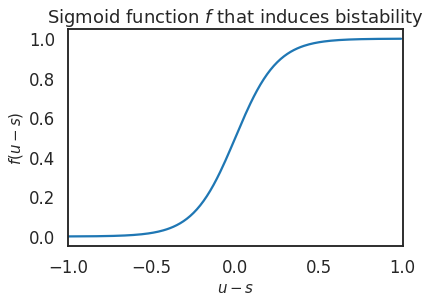

In [188]:
# plot
u_s = np.arange(-1, 1, 0.01)
production = []
for k in u_s:
    production.append(sigma(2*k))
    
plt.plot(u_s, production);
plt.xlim(-1, 1);
plt.xlabel('$u-s$', size=15);
plt.ylabel('$f(u-s)$', size=15);
plt.title('Sigmoid function $f$ that induces bistability');

# Define ligand activity based on cell-cell distance

This function can be made steeper by increasing the 2 in the $\tanh$ term in the equation for $\sigma$, or shallower by decreasing that number, but making it too shallow will destroy the bistability of the system. 

The signal that one cell receives from another is an exponentially decaying function of the distance between the two cells. This function $s$ is defined as follows: 
$$s_i = \sum_{j, j \ne i} e^{- d_{ij}^2/2l^2} \Big(a_0 + \frac{3 u_j^3}{1 + u_j^2} a_1\Big) u_j$$
The sum over all $j$ indicates that every cell contributes to the inhibitory signal, but the $e^{-d_{ij}^2/2l^2}$ term ensures that this contribution will be smaller as the distance between cells increases. The distance between cells $i$ and $j$ is defined as $d_{ij}$, while the variable $l$ defines the rate at which this strength of the signal falls off with distance. For example, larger values of $l$ will lead to a sparser pattern with more space in between the high state cells, while decreasing $l$ will lead to a denser pattern. Here $l$ is decreased from the parameter given in the paper to achieve a pattern where every other cell goes high in state. 

The term in parentheses in the above equation defines the non-linearity of signaling. More discussion of this was given in the paper, but the shape of the curve was chosen so that the trajectories of groups of identical cells will pass through the bistable regime in $u-s$ space (Fig. 4B in the paper). Here, this function (including the values of $a_0, a_1$) are unchanged from the paper. Finally, the last $u$ term in the right hand side means that the higher the state of a cell, the stronger its inhibitory signal will be. 

In [5]:
def a(u):
    '''Function a(u) (Eq. 11) from paper for ligand activity
    Args:
        u -- float between [0,1] indicating cell state and activating signal level
    Returns:
        a -- float value of ligand activity
    '''
    a = a_0 + ((3*u**3)/(1 + u**2)) * a_1
    return a

In [6]:
def D(u):
    """
    '''Function for Ligand level'''
    """
    return u

In [7]:
def inhibitory_signal(u_list, pos):
    """ 
    Calculates total inhibitory signal received by cell at index pos with neighbors at states in x
    Eq. 8
    Args:
        u_list -- list of states for each cell in the simlation
        pos -- index of cell
    Returns:
        s -- summed inhibitory signal for cell-i with index pos
    """
    s = 0 # inhibitory signal initialize
    
    for cell in range(0, cells):
        # calculate cell-cell distance
        d = np.abs(cell-pos)
        if d!=0: # don't include self-cell
            # periodic boundary distance correction
            if d > cells/2: 
                d = np.abs(cells - d)
            
            # calculate coupling between cells i and j (Eq. 9)
            cij = np.exp(-(d*lam)**2/(2*l**2))
            
            # update summed inhibitory signal s from neighbor cell j
            uj = u_list[cell]
            s += cij*a(uj)*D(uj) # Eq. 8-10
            
    return s

# Patterning driver

In [8]:
def pattern(dt, t_max, cells):
    """
    Args:
        dt -- float time step 
        t_max -- float total simulation time
        cells -- int number of cells in simulation
    Returns:
        u_store -- float of u values over time for each cell
        s_store -- float of s values over time for each cell
        t_store -- float time step array
    """
    t = 0 # start time
    steps = int(t_max/dt) # number of time-steps
    #print(f'Steps = {steps}')
    
    # Arrays to hold values of u and s for each cell for current time point
    master_array = np.zeros((2, cells))
    errors = []
    
    # arrays to store u and s values over time
    u_store = np.zeros((steps+1, cells)) # add 1 for initial time=0 values stored
    s_store = np.zeros((steps+1, cells))
    
    for step in range(1, steps+1): # step 0 has already been initialized
        # current signal levels for all cells
        u = master_array[0]
        s = master_array[1]
        
        # update s
        for j in range(cells):
            master_array[1][j] = inhibitory_signal(u, j) # calculate inhibitory signal received by each cell
        
        s_store[step] = master_array[1]
        s = master_array[1]
        
        # update u
        for k in range(cells):
            # Euler-Maruyama equation for weiner noise
            dW = np.random.normal(loc=0, scale=np.sqrt(dt), size=1) # for a single cell
            du = (1/tau)*( sigma(2*(u[k]-s[k])) - u[k] )*dt  + D_Noise*dW  # corson equation # independent noise term
                        
            master_array[0][k] += du
            
            # state cannot be lower than 0
            if master_array[0][k] <=0:
                master_array[0][k] = 0
            
        u_store[step] = master_array[0]
        
        # update time 
        t += dt
        
        if t == t_max: # at end time
            return u_store, s_store, np.arange(0, t, dt)

# Model and simulation parameters

In [9]:
# model params
lam = 5e-4       # Intercellular distance lambda
l = 0.75*lam     # Length scale of signal decay  (change this to get different SOP spacings)
a_0 = 0.05       # constant for Eq. 11
a_1 = 1 - a_0    # as desctibed in Corson et al

D_Noise  = 0.01  # Process Noise (tune this to increase or decrease noise in cell state dynamics)
tau = 5          # Process  time scale of pattern formation - ratio between process scale/protein persistence
tau_max = tau*5  # maximum simulation time (assume 5-10 lifetimes turnover)

In [10]:
# default simulation params
cells = 20               # Number of cells
dt = 1                   # Time step (must be less than tau)
t_max = 10*tau_max       # Total simulation time

# Run simulation with different noise levels

In [86]:
# test different D_Noise values
Dnoise_array = [1e-4, 0.05]

Steps = 250
Steps = 250


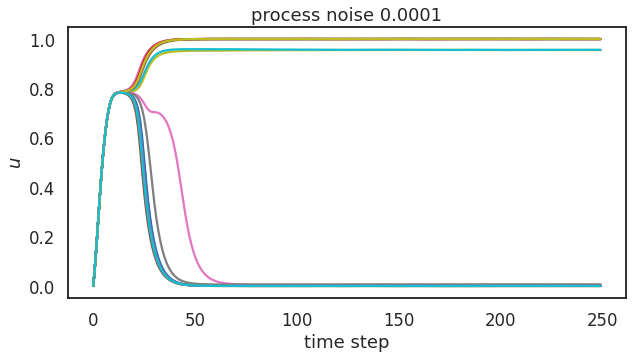

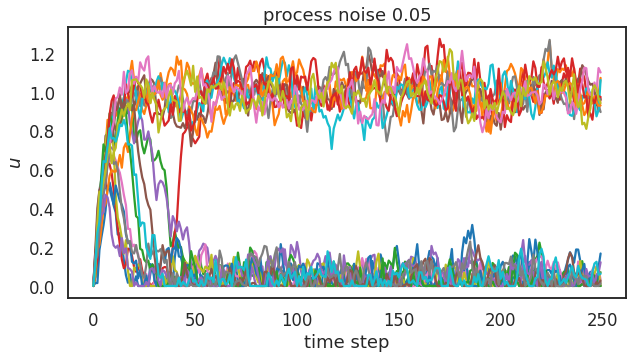

In [87]:
for n in Dnoise_array:
    D_Noise = n # set parameter
    
    # run simulation
    u_store, s_store, t_store = pattern(dt, t_max, cells)
    
    # plot trajectories
    plt.figure(figsize=(10,5))
    for cell_id in range(cells):
        traj = []
        for step in range(t_store.shape[0]):
            traj.append(u_store[step][cell_id])

        plt.plot(t_store, traj,);
        plt.xlabel('time step');
        plt.ylabel('$u$');
        plt.title(f'process noise {n}');

# Representative simulations for process noise 0.01

## Time traces

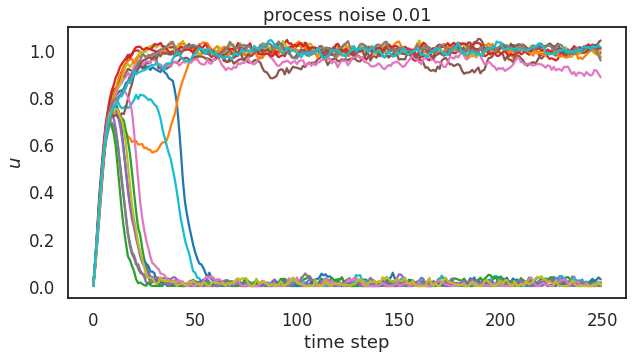

In [18]:
n = 0.01
D_Noise = n

# run simulation
u_store, s_store, t_store = pattern(dt, t_max, cells)

# plot trajectories
plt.figure(figsize=(10,5))
for cell_id in range(cells):
    traj = []
    for step in range(t_store.shape[0]):
        traj.append(u_store[step][cell_id])

    plt.plot(t_store, traj,);
    plt.xlabel('time step');
    plt.ylabel('$u$');
    plt.title(f'process noise {n}');
plt.savefig('Time traces of single-cell dynamics.pdf', dpi=300)
plt.show()

## 1D array representation

In [150]:
initial_state = np.expand_dims(u_store[1], axis=0)
intermid_state = np.expand_dims(u_store[15], axis=0)
final_state = np.expand_dims(u_store[50], axis=0)

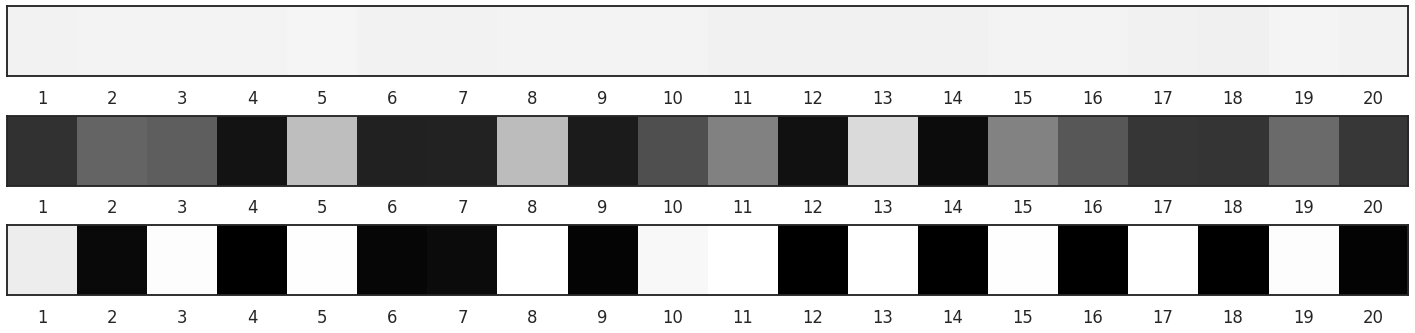

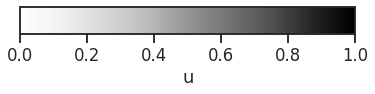

In [184]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20,5))

for array, ax in zip([initial_state, intermid_state, final_state], axes.flat):
    ax.imshow(array, cmap=mpl.cm.Greys, vmin=0, vmax=1)
    ax.set_xticks(ticks=list(range(20)))
    ax.set_xticklabels(labels=list(range(1,21)))
    ax.set_yticklabels(labels=[])
plt.savefig('Cell array Sens levels.pdf')
plt.tight_layout()
plt.show() 

# plot the colorbar
fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

cmap = mpl.cm.Greys
norm = mpl.colors.Normalize(vmin=0, vmax=1)

cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
cb1.set_label('u')
fig.savefig('colorbar for u.pdf')
fig.show()

# Plot state distributions over time

## Process noise 0.01

In [161]:
# run multiple loops
u_sims = []
nSims = 100 # number of simulation runs
for loop in tqdm(range(nSims)):
    D_Noise = 0.01
    cells = 20 
    # run simulation
    u_store, s_store, t_store = pattern(dt, t_max, cells)
    u_sims.append(u_store)

100%|██████████| 100/100 [01:43<00:00,  1.03s/it]


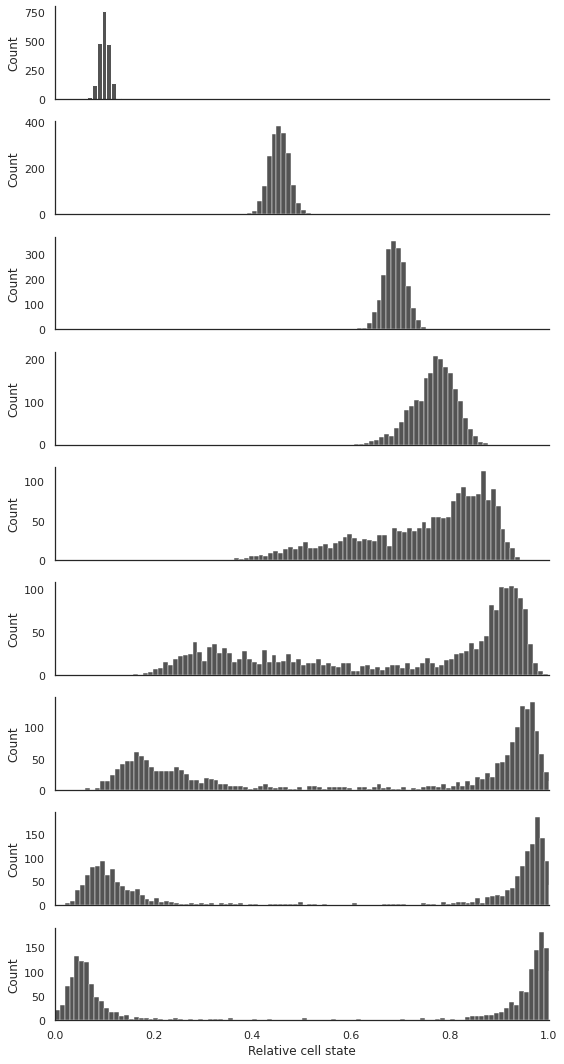

In [230]:
sns.set_context('notebook')
sns.set_style('white')

fig, axes = plt.subplots(nrows=9, sharex=True, figsize=(8,15))

for t,ax  in zip(range(1,27,3), axes.flat):
    # get all the sim u values for given time t
    ut = []
    for u_store in u_sims:
        ut.extend(u_store[t])
        
    # plot for given time
    sns.histplot(ut, binwidth=0.01, color='k', ax=ax)
    sns.despine( ax=ax)
    #sns.despine(bottom=False, left=False, ax=ax)
    ax.set_xlim([0,1]);
    
    #ax.title(f'time {t}')
plt.subplots_adjust(hspace=-.2)
plt.xlabel('Relative cell state');
plt.tight_layout()
plt.autoscale()
plt.savefig('Ridgeplot of bistable dynamics.pdf', dpi=300)
plt.show()